In [1]:
import numpy as np
import matplotlib.pyplot as plt


In [2]:
from coco_utils import load_coco_data, sample_coco_minibatch, decode_captions
from image_utils import image_from_url


In [3]:
def show_image(batch_size):
    captions, features, urls = sample_coco_minibatch(data, batch_size=batch_size)
    for i, (caption, url) in enumerate(zip(captions, urls)):
        plt.imshow(image_from_url(url))
        plt.axis('off')
        caption_str = decode_captions(caption, data['idx_to_word'])
        plt.title(caption_str)
        plt.show()


In [4]:
data = load_coco_data(pca_features=True)

In [5]:
for k, v in data.items():
    if type(v) == np.ndarray:
        print(k, type(v), v.shape, v.dtype)
    else:
        print(k, type(v), len(v))

val_urls <class 'numpy.ndarray'> (40504,) <U63
val_captions <class 'numpy.ndarray'> (195954, 17) int32
val_features <class 'numpy.ndarray'> (40504, 512) float32
idx_to_word <class 'list'> 1004
val_image_idxs <class 'numpy.ndarray'> (195954,) int32
train_image_idxs <class 'numpy.ndarray'> (400135,) int32
train_captions <class 'numpy.ndarray'> (400135, 17) int32
train_features <class 'numpy.ndarray'> (82783, 512) float32
word_to_idx <class 'dict'> 1004
train_urls <class 'numpy.ndarray'> (82783,) <U63


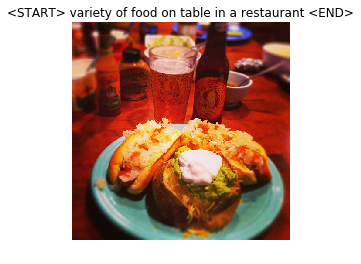

In [6]:
show_image(1)

In [7]:
def sparse_to_one_hot(sparse_input, max_dim):
    one_hot = np.zeros((sparse_input.shape[0], max_dim))
    for idx, input_index in enumerate(sparse_input):
        one_hot[idx, input_index] = 1
    return one_hot

def captions_to_one_hot(captions, vocab_dim):
    return [sparse_to_one_hot(sentence, vocab_dim) for sentence in captions]

def captions_to_target(captions, null_token_represenation):
    
    def trim_left_and_pad_right(caption):
        """
        Convert training data:
        '<START> a variety of fruits and vegetables sitting on a kitchen counter <END>'
        to target:
        'a variety of fruits and vegetables sitting on a kitchen counter <END> <NULL>'
        """
        return np.append(caption[1::], null_token_represenation)
    
    return [trim_left_and_pad_right(c) for c in captions]

def verify_caption_train_target_offset(train_caption, target_caption):
    for i in range(len(target_caption) - 1):
        assert train_caption[i + 1] == target_caption[i]

In [8]:
import tensorflow as tf
import matplotlib.pyplot as plt
import layer_utils 

## word preprocess
vocab_dim = len(data['word_to_idx'])
START_TOKEN = '<START>'
END_TOKEN = '<END>'
NULL_TOKEN = '<NULL>'


## model params
word_embedding_dim = 256
hidden_dim = 512
learning_rate = 0.001

def get_train_target_caption(train_captions_as_word_ids):
    """
        convert captions from word ids to representations [N, T, V], batch size, time step, and vocab size
    """

    target_captions_as_word_ids = captions_to_target(train_captions_as_word_ids, data['word_to_idx'][NULL_TOKEN])
    verify_caption_train_target_offset(train_captions_as_word_ids[0], target_captions_as_word_ids[0])

    train_captions = captions_to_one_hot(train_captions_as_word_ids, vocab_dim)
    target_captions = captions_to_one_hot(target_captions_as_word_ids, vocab_dim)
    return train_captions, target_captions


In [9]:

sy_caption_input = tf.placeholder(shape=[None, None, vocab_dim], name="caption_input", dtype=tf.float32)
sy_caption_target = tf.placeholder(shape=[None, None, vocab_dim], name="caption_target", dtype=tf.int32)



word_embedding = layer_utils.build_mlp(sy_caption_input, word_embedding_dim, 'word_embedding', activation=tf.nn.relu)


In [10]:
cell = tf.nn.rnn_cell.LSTMCell(hidden_dim)
outputs, final = tf.nn.dynamic_rnn(cell, word_embedding, time_major=False, dtype=tf.float32)
hidden_to_word = layer_utils.build_mlp(outputs, vocab_dim, 'hidden_to_word', activation=tf.nn.relu)
word_label_dist = tf.nn.softmax(hidden_to_word)
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=sy_caption_target, logits=hidden_to_word))
update_op = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy)


In [11]:
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

In [25]:
def sample_caption(initial_word, limit_length):
    
    generated_word_idx = []
    for _ in range(limit_length):
        caption_input = [[initial_word]]
        dist = sess.run([word_label_dist], {sy_caption_input: caption_input})
        
        sampled_word_id = np.argmax(dist[0][0][0])
        
        next_word_input = np.zeros(len(initial_word))
        next_word_input[sampled_word_id] = 1
        initial_word = next_word_input

        generated_word_idx.append(sampled_word_id)

    return generated_word_idx
    


In [ ]:
iter_num = 1000

for i in range(iter_num):
    mini_batch, _, url = sample_coco_minibatch(data,  batch_size=100, split='train')
    train_captions, target_captions = get_train_target_caption(mini_batch)
    o, c = sess.run([update_op, cross_entropy], {sy_caption_input: train_captions, sy_caption_target: target_captions})
    print("iter {}: {}".format(i, c))

In [26]:
sample_caption(train_captions[20][1], 15)

[3, 6, 3, 6, 3, 6, 3, 6, 3, 6, 3, 6, 3, 6, 3]